<a href="https://colab.research.google.com/github/maguid28/CS6271-EvolutionaryComputation/blob/main/Q4ATTEMPT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Comments:



   # GA applied to OneMax

This notebook implements a simple GA in a fairly lowlevel way. In later examples we'll use more highlevel operators, but it is a very valuable exercise to ensure you understand what this code is actually doing. Make sure you understand the processes below before moving to the more high-level toolboxes!

Install DEAP. Note that if you are running this on your own computer you might not need to do this. In fact, it is better practice to install it so that it is always available, but when running on Colab, we do need this.

In [776]:
!pip install deap

Import the DEAP tools and useful libraries (random and matplotlib).

In [777]:
from deap import base
from deap import creator
from deap import tools

import random

import matplotlib.pyplot as plt

Set our Genetic Algorithm parameters

In [778]:
NBR_ITEMS = 100
MAX_WEIGHT = 1000

# set the random seed. Make sure you do this BEFORE creating the knapsack
# creating the knapsack
RANDOM_SEED = 42
random.seed(RANDOM_SEED)

# Create the item dictionary: item name is an integer, and value is
# a (value, weight) 2-uple.

items = {}

# Create random items and store them in the items' dictionary.
for i in range(NBR_ITEMS):
     items[i] = (random.randint(1, 10), random.randint(1, 100))

In [779]:
# Genetic Algorithm constants:
# DO NOT TOUCH
POPULATION_SIZE = 500


P_CROSSOVER = 0.7  # probability for crossover
P_MUTATION = 1/NBR_ITEMS   # probability for mutating an individual
MAX_GENERATIONS = 10000


In [780]:
#penalty weight
penalty_weight = 1
#Use to determine how often to adjust the penalty
ADJUSTMENT_INTERVAL = 1

Create our toolbox. Note that we can pull in a bunch of predefined operators to tailor our Evolutionary Algorithm, which, of course, in this case is a GA. Notice that it is possible to create our **own** operators and functions to use, which is what we do with our **oneMaxFitness** function below.

In [781]:
toolbox = base.Toolbox()

# create an operator that randomly returns 0 or 1:
toolbox.register("zeroOrOne", random.randint, 0, 1)

# define a single objective, maximizing fitness strategy:
creator.create("FitnessMax", base.Fitness, weights=(1.0,))

# create the Individual class based on list:
creator.create("Individual", list, fitness=creator.FitnessMax)
#creator.create("Individual", array.array, typecode='b', fitness=creator.FitnessMax)

# create the individual operator to fill up an Individual instance:
toolbox.register("individualCreator", tools.initRepeat, creator.Individual, toolbox.zeroOrOne, NBR_ITEMS)

# create the population operator to generate a list of individuals:
toolbox.register("populationCreator", tools.initRepeat, list, toolbox.individualCreator)

def knapsackFitness(individual):
    total_weight = 0.0
    total_value = 0.0

    for (selected, (item_value, item_weight)) in zip(individual, items.values()):
        if selected:
            total_weight += item_weight
            total_value += item_value

    if total_weight > MAX_WEIGHT:
        penalty = penalty_weight * (total_weight - MAX_WEIGHT)
        total_value -= penalty
    return total_value,



toolbox.register("evaluate", knapsackFitness)

# genetic operators:

# Tournament selection with tournament size of 2:
toolbox.register("select", tools.selTournament, tournsize=2)

# Single-point crossover:
toolbox.register("mate", tools.cxOnePoint)

# Flip-bit mutation:
# indpb: Independent probability for each attribute to be flipped
toolbox.register("mutate", tools.mutFlipBit, indpb=1.0/NBR_ITEMS)



In [782]:
def genetic_algorithm(P_CROSSOVER=0.7, P_MUTATION=1.0/100, penalty_weight=1):

  previousBestFitness = 0
  stagnantGenerations = 0

  best_individual_overall = None
  best_fitness_overall = 0
  best_weight_overall = 0

  # create initial population (generation 0):
  population = toolbox.populationCreator(n=POPULATION_SIZE)
  generationCounter = 0

  # calculate fitness tuple for each individual in the population:
  fitnessValues = list(map(toolbox.evaluate, population))
  for individual, fitnessValue in zip(population, fitnessValues):
      individual.fitness.values = fitnessValue

  # extract fitness values from all individuals in population:
  fitnessValues = [individual.fitness.values[0] for individual in population]

  # initialize statistics accumulators:
  maxFitnessValues = []
  meanFitnessValues = []

  # main evolutionary loop:
  # stop if max fitness value reached the known max value
  # OR if number of generations exceeded the preset value:
  while max(fitnessValues) < NBR_ITEMS and generationCounter < MAX_GENERATIONS:
      # update counter:
      generationCounter = generationCounter + 1

      # apply the selection operator, to select the next generation's individuals:
      offspring = toolbox.select(population, len(population))
      # clone the selected individuals:
      offspring = list(map(toolbox.clone, offspring))

      # apply the crossover operator to pairs of offspring:
      for child1, child2 in zip(offspring[::2], offspring[1::2]):
          if random.random() < P_CROSSOVER:
              toolbox.mate(child1, child2)
              del child1.fitness.values
              del child2.fitness.values

      for mutant in offspring:
          if random.random() < P_MUTATION:
              toolbox.mutate(mutant)
              del mutant.fitness.values

      # calculate fitness for the individuals with no previous calculated fitness value:
      freshIndividuals = [ind for ind in offspring if not ind.fitness.valid]
      freshFitnessValues = list(map(toolbox.evaluate, freshIndividuals))
      for individual, fitnessValue in zip(freshIndividuals, freshFitnessValues):
          individual.fitness.values = fitnessValue

      # replace the current population with the offspring:
      population[:] = offspring

      # collect fitnessValues into a list, update statistics and print:
      fitnessValues = [ind.fitness.values[0] for ind in population]


      maxFitness = max(fitnessValues)
      meanFitness = sum(fitnessValues) / len(population)
      maxFitnessValues.append(maxFitness)
      meanFitnessValues.append(meanFitness)
      print("- Generation {}: Max Fitness = {}, Avg Fitness = {}".format(generationCounter, maxFitness, meanFitness))

      best_index = fitnessValues.index(max(fitnessValues))
      print("Best Individual = ", *population[best_index])

      best_individual = population[best_index]
      best_individual_weight = sum(item_weight for selected, (_, item_weight) in zip(best_individual, items.values()) if selected)

      if maxFitness > best_fitness_overall:
        best_fitness_overall = maxFitness
        best_individual_overall = population[best_index]
        best_weight_overall = best_individual_weight

      best_weight = sum(item[1] for i, item in enumerate(items.values()) if best_individual[i] == 1)
      print("Total weight for the best individual: " + str(best_weight) +  "\n")

      if generationCounter % ADJUSTMENT_INTERVAL == 0:
        if best_individual_weight > MAX_WEIGHT:
            penalty_weight *= 1.08

      # Stagnation check:
      if previousBestFitness == maxFitness:
          stagnantGenerations += 1
      else:
          stagnantGenerations = 0  # reset if there's improvement
      previousBestFitness = maxFitness
      if stagnantGenerations >= 25:
          print("No improvement in the last 25 generations")
          break

  print("\nBest Individual Overall = ", *best_individual_overall)
  print("Fitness of Best Individual Overall = ", best_fitness_overall)
  print("Total Weight for the Best Individual Overall: ", best_weight_overall)

  return maxFitnessValues, meanFitnessValues




- Generation 1: Max Fitness = -479.0, Avg Fitness = -1211.938
Best Individual =  1 0 1 0 0 1 1 1 1 0 1 1 0 1 0 0 1 0 0 0 1 1 0 0 0 1 0 0 0 0 0 0 1 1 1 0 1 0 0 1 0 0 1 0 0 1 1 1 0 0 1 0 1 1 0 0 0 1 1 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 1 1 0 0 0 0 0 0 0 1 1 0 0 0 0 0 1 0 1 1 0 0 1 0 1 0
Total weight for the best individual: 1678

- Generation 2: Max Fitness = -479.0, Avg Fitness = -1067.448
Best Individual =  1 0 1 0 0 1 1 1 1 0 1 1 0 1 0 0 1 0 0 0 1 1 0 0 0 1 0 0 0 0 0 0 1 1 1 0 1 0 0 1 0 0 1 0 0 1 1 1 0 0 1 0 1 1 0 0 0 1 1 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 1 1 0 0 0 0 0 0 0 1 1 0 0 0 0 0 1 0 1 1 0 0 1 0 1 0
Total weight for the best individual: 1678

- Generation 3: Max Fitness = -391.0, Avg Fitness = -926.258
Best Individual =  0 1 1 0 1 0 0 0 0 1 1 0 1 0 0 0 0 1 0 0 0 0 1 0 0 1 1 0 0 0 1 0 0 1 1 0 1 0 0 0 0 0 1 1 0 0 1 0 1 1 0 0 0 1 1 1 0 1 1 0 0 1 0 1 0 0 0 1 0 0 0 1 1 1 1 0 1 1 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 1 1
Total weight for the best individual: 1606

- Generation 4: Max Fitnes

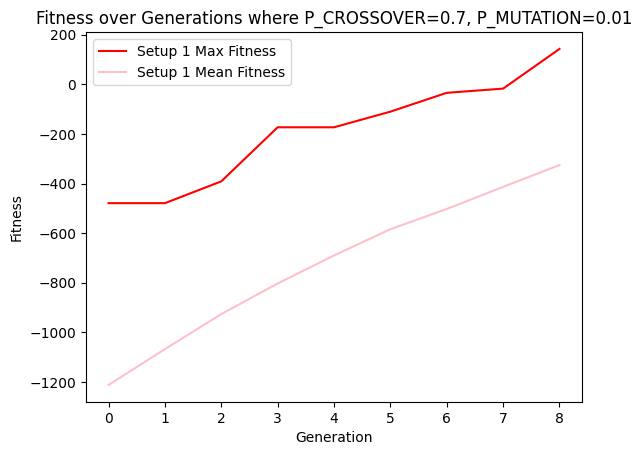

In [783]:
max_vals_1, mean_vals_1 = genetic_algorithm(P_CROSSOVER=0.7, P_MUTATION=0.01)

plt.plot(max_vals_1, color='red', label='Setup 1 Max Fitness')
plt.plot(mean_vals_1, color='pink', label='Setup 1 Mean Fitness')
plt.xlabel('Generation')
plt.ylabel('Fitness')
plt.title('Fitness over Generations where P_CROSSOVER=0.7, P_MUTATION=0.01')
plt.legend()
plt.show()

- Generation 1: Max Fitness = -380.0, Avg Fitness = -1207.592
Best Individual =  1 1 0 0 0 1 1 0 0 0 1 1 0 1 0 1 0 0 0 1 1 0 0 1 0 1 0 0 0 0 0 0 1 1 1 0 0 1 1 0 1 0 0 0 1 1 0 0 0 1 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 1 1 1 1 1 0 0 0 0 0 0 0 1 1 0 0 0 1 0 0 0 0 1 1 0 0 0 1 0 1 0 0 0 0 0
Total weight for the best individual: 1563

- Generation 2: Max Fitness = -426.0, Avg Fitness = -1069.14
Best Individual =  1 0 1 0 0 0 0 1 0 0 0 0 0 0 1 0 1 1 0 1 0 1 0 0 0 0 0 1 0 0 1 1 0 1 1 0 0 0 0 0 0 1 0 0 0 1 0 0 1 0 0 0 0 1 1 1 0 0 1 0 0 0 1 1 1 1 0 0 0 1 0 0 0 0 1 0 0 0 0 1 0 1 0 1 0 0 0 0 1 1 1 0 1 1 0 0 0 0 0 1
Total weight for the best individual: 1597

- Generation 3: Max Fitness = -409.0, Avg Fitness = -955.356
Best Individual =  0 0 1 0 0 1 0 0 0 0 1 0 1 0 0 0 0 0 1 1 0 1 0 1 1 1 0 0 0 1 0 0 0 0 0 0 1 0 1 0 1 1 1 0 0 1 0 0 1 1 0 0 0 1 0 0 0 0 1 1 1 0 0 0 0 1 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1 1 0 1 1 0 0 1 1 0 0 1 0
Total weight for the best individual: 1592

- Generation 4: Max Fitness

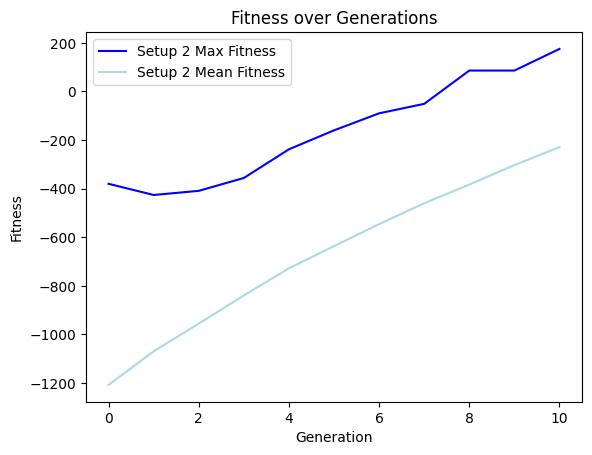

In [792]:
max_vals_2, mean_vals_2 = genetic_algorithm(P_CROSSOVER=0.9, P_MUTATION=0.01,penalty_weight=1.1)

plt.plot(max_vals_2, color='blue', label='Setup 2 Max Fitness')
plt.plot(mean_vals_2, color='lightblue', label='Setup 2 Mean Fitness')
plt.xlabel('Generation')
plt.ylabel('Fitness')
plt.title('Fitness over Generations')
plt.legend()
plt.show()